# Прогнозирование конверсии рекламного показа в установку мобильного приложения для рекламного брокера


| **Участники проекта**       |                
| ---------------------------- |
| Воробкин Артём Станиславович |
| Голубев Роман Олегович       |
| Смирнова Анастасия Максимовна|
| Ширяева Алиса Вячеславовна   |



# Информация о проекте

**Компания:** рекламный брокер, который закупает показы рекламы в мобильных приложениях и перепродает их рекламодателям.

**Продукт:** брокерская рекламная платформа, которая должна помогать рекламодателям точнее таргетировать аудиторию и снижать издержки на неэффективные показы. Решение задачи прогнозирования конверсии встроено в рекомендательный движок брокера и позволяет в реальном времени определять, стоит ли показывать конкретному пользователю ту или иную рекламу.

**Проблема продукта:** Показы рекламы стоят денег, но не каждый показ приводит к установке приложения. В результате рекламодатель тратит средства на неэффективный трафик.

**Описание данных.**

В таблице `advertisers` содержится история показов рекламы в мобильных приложениях:

- `install` — конверсия показа в установку;

- `user id` — id пользователя, которому была показана реклама;

- `game app` — id приложения, в котором была показана реклама;

- `country` — страна пользователя;

- `advertiser` — id рекламного аукциона, который выбирает рекламу для показа;

- `age` — возрастная группа пользователя (1: 18–25, 2: 26–35, 3: 36–45, 4: 46–55, 5: 55+)

- `user quality score` — уровень «качества» пользователя, выставленный отдельной ML-моделью (1 — низкая вероятность конверсии, 2 — средняя, 3 — высокая);

- `сreatedat` — дата показа рекламы;

- `spending` — стоимость показа рекламы;

- `earning` — плата от рекламодателя за установку;

- `mccmnc` — оператор мобильной связи пользователя.

**Задачи:**

1) Изучить датасет, провести EDA, предоставить бизнес-заказчикам практические инсайты, поддерживающие принятие решений на основе данных.

2) Сформулировать аналитические выводы для ML-отдела для последующей разработки модели, прогнозирующей прибыльность рекламного показа.

3) Подготовить дашборд, который содержит графики и визуализации, отражающие ключевые выводы анализа данных. Он должен демонстрировать выявленные закономерности и инсайты, быть понятным для пользователей без технической подготовки и служить инструментом для принятия решений на основе данных.

# Импорты библиотек

In [1]:
# Стандартные библиотеки Python
import sys
import warnings

# Научные вычисления и работа с данными
import numpy as np
import pandas as pd

# Визуализация
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import PercentFormatter, FuncFormatter
import seaborn as sns

# Интерактивная визуализация
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Статистика
import scipy.stats as st
from scipy.stats import levene, ttest_ind, mannwhitneyu, shapiro
from statsmodels.stats.proportion import proportions_ztest

# Дополнительные инструменты
import gradio as gr

# Настройки
warnings.filterwarnings("ignore")

# Чтение данных

Считаем данные из таблицы `advertisers`.

In [2]:
df_path = "advertisers.csv"

advertisers = pd.read_csv(df_path)

advertisers.head()

,install,user id,game app,country,advertiser,age,user quality score,createdat,spending,earning,carrier,mccmnc
0,0,user_045828,game_2,AU,advertiser_01,1,1,1675578699,0.014110,0.0,carrier_11,505244
1,0,user_150401,game_4,GB,advertiser_22,5,2,1676420955,0.005462,0.0,carrier_1,234014
2,0,user_102674,game_4,DE,advertiser_07,1,3,1676034552,0.020445,0.0,carrier_17,262203
3,0,user_290419,game_4,AU,advertiser_11,5,3,1677552033,0.010014,0.0,carrier_0,505604
4,0,user_070536,game_5,DE,advertiser_13,4,2,1675775984,0.014186,0.0,carrier_7,262897


# EDA

In [3]:
def df_info(df, df_name=None):
    """
    Выводит информацию о датасете.

    Parameters:
        df (pd.DataFrame): Датафрейм для обработки.
        df_name (str): Название датафрейма (для отображения).
    """

    # Шапка вывода
    print('-' * 10, '' * 5,
          f'Информация о датафрейме {str(df_name)}: ',
          '' * 5, '-' * 10)
    print()

    # 1. Количество строк
    row_count = df.shape[0]  # Возвращаем информацию о количестве строк
    print(f'1) Количество строк: {row_count}')

    # 2. Количество столбцов
    column_count = df.shape[1]  # Возвращаем информацию о количестве столбцов
    print(f'2) Количество столбцов: {column_count}')

    # 3. Типы данных
    columns = df.dtypes  # Возвращаем информацию столбцах и типах данных
    print('3) Типы данных:')
    print()
    print(columns)
    print()

    # 4. Доля пропусков
    is_null = df.isna().mean() * 100  # Возвращаем количество пропусков
    print('4) Доля пропусков в каждом из столбцов:')
    print()
    print(is_null)
    print()

    # 5. Дубликаты
    duplicate_count = df.duplicated().sum()  # Дубликаты
    duplicate_percentage = duplicate_count / len(df) * 100
    print(f'5) Полных дубликатов: {duplicate_count} '
          f'({duplicate_percentage:.2f}%)')

In [4]:
# Применяем функцию
df_info(advertisers, 'advertisers')

----------  Информация о датафрейме advertisers:   ----------

1) Количество строк: 50000
2) Количество столбцов: 12
3) Типы данных:

install                 int64
user id                object
game app               object
country                object
advertiser             object
age                     int64
user quality score      int64
createdat               int64
spending              float64
earning               float64
carrier                object
mccmnc                  int64
dtype: object

4) Доля пропусков в каждом из столбцов:

install               0.0
user id               0.0
game app              0.0
country               0.0
advertiser            0.0
age                   0.0
user quality score    0.0
createdat             0.0
spending              0.0
earning               0.0
carrier               0.0
mccmnc                0.0
dtype: float64

5) Полных дубликатов: 0 (0.00%)


- В данных содержится один столбец, не заявленный в исходном описании - `carrier`.

- Пропусков и полных дубликатов нет.

- Представлены следующие типы данных:
  - `int64` для столбцов `install`, `age `, `user quality score`, `createdat`, `mccmnc`,
  - `object` для столбцов `user id`, `game app`, `country`, `advertiser`, `carrier`,
  - `float64` для столбцов `spending` и `earning`.

Потребуется преобразование столбца `createdat` к типу `datetime`. Также можно преобразовать столбцы, содержащие категориальные данные к типу `categorical` (например, `game app`, `country`, `advertiser`, `carrier`, `mccmnc `). Столбцы `age` и `user quality score` также преобразуем, однако с сохранением порядка значений, заявленного в описании к данным.

Кроме того, для повышения производительности можно выполнить понижение разрядности в столбцах, содержащих числовые данные.

- Наименования столбцов в таблице приведены не в соответствии с snake_case. Для дальнейшего удобства работы, потребуется преобразовать их к корректному формату.

Для преобразования наименований столбцов напишем функцию `to_snake_case()`.

In [5]:
def to_snake_case(df):
    """
    Приводит названия столбцов DataFrame к snake_case.

    Параметры:
        df (pd.DataFrame): Исходный DataFrame

    Возвращает:
        pd.DataFrame: DataFrame с преобразованными названиями столбцов
    """
    # Создаем словарь переименования
    new_columns = {}

    for col in df.columns:
        # Приводим к строке, заменяем пробелы, приводим к нижнему регистру
        new_name = str(col).replace(' ', '_').lower()
        new_columns[col] = new_name

    # Возвращаем результат
    return df.rename(columns=new_columns)


# Применяем функцию
advertisers = to_snake_case(advertisers)

# Проверяем замену наименований
advertisers.columns

Index(['install', 'user_id', 'game_app', 'country', 'advertiser', 'age',
       'user_quality_score', 'createdat', 'spending', 'earning', 'carrier',
       'mccmnc'],
      dtype='object')

Замена наименований проведена успешно.
Следующим шагом изменим тип данных в столбце `createdat`. Для этого применим метод `pd.to_datetime()` с параметром `unit='s'`.

In [6]:
# Меняем тип данных в столбце `createdat`
advertisers['createdat'] = pd.to_datetime(advertisers['createdat'], unit='s')

advertisers['createdat'].head()

,createdat
0,2023-02-05 06:31:39
1,2023-02-15 00:29:15
2,2023-02-10 13:09:12
3,2023-02-28 02:40:33
4,2023-02-07 13:19:44


Теперь преобразуем нужные столбцы в категориальные признаки. Для этого напишем функцию `optimize_categorical_columns()`.

In [7]:
def optimize_categorical_columns(df):
    """
    Оптимизирует категориальные столбцы в датафрейме advertisers.
    Изменяет исходный датафрейм inplace.

    Преобразования:
    - 'game_app', 'country', 'advertiser', 'mccmnc' -> обычная категория
    - 'age', 'user_quality_score' -> упорядоченная категория

    Параметры:
        df (pd.DataFrame): Датафрейм для оптимизации (изменяется inplace)
    """

    # 1. Обычные категориальные столбцы (без порядка)
    regular_categorical = [
        'game_app',
        'country',
        'advertiser',
        'carrier',
        'mccmnc'
    ]

    for col in regular_categorical:
        if col in df.columns:
            if str(df[col].dtype) != 'category':
                df[col] = df[col].astype('category')
                print(
                    f"{col}: преобразован в категорию "
                    f"({df[col].nunique()} уникальных значений)"
                )

    # 2. Упорядоченные категориальные столбцы
    # age: 1 (18-25), 2 (26-35), 3 (36-45), 4 (46-55), 5 (55+)
    if 'age' in df.columns:
        if str(df['age'].dtype) != 'category':
            age_categories = pd.CategoricalDtype(
                categories=[1, 2, 3, 4, 5],
                ordered=True
            )
            df['age'] = df['age'].astype(age_categories)
            print("age: упорядоченная категория [1, 2, 3, 4, 5]")

    # user_quality_score: 1 (низкая), 2 (средняя), 3 (высокая)
    if 'user_quality_score' in df.columns:
        if str(df['user_quality_score'].dtype) != 'category':
            quality_categories = pd.CategoricalDtype(
                categories=[1, 2, 3],
                ordered=True
            )
            df['user_quality_score'] = df['user_quality_score'].astype(
                quality_categories
            )
            print("user_quality_score: упорядоченная категория [1, 2, 3]")

    print("\nОптимизация категориальных столбцов завершена.")

In [8]:
# Применяем функцию
optimize_categorical_columns(advertisers)

game_app: преобразован в категорию (7 уникальных значений)
country: преобразован в категорию (7 уникальных значений)
advertiser: преобразован в категорию (30 уникальных значений)
carrier: преобразован в категорию (20 уникальных значений)
mccmnc: преобразован в категорию (413 уникальных значений)
age: упорядоченная категория [1, 2, 3, 4, 5]
user_quality_score: упорядоченная категория [1, 2, 3]

Оптимизация категориальных столбцов завершена.


Преобразование выполнено успешно. Следующим шагом применим понижение разрядности к столбцам, содержащим числовые типы данных. Для этого напишем функцию `downcast()`

In [9]:
def downcast(df):
    """
    Выполняет понижение разрядности числовых столбцов датафрейма
    с типами int64 и float64 для экономии памяти.
    Преобразует int64 → int8/int16/int32 и float64 → float32.

    Параметры:
        df (pandas.DataFrame): Датафрейм для обработки.

    Возвращает:
        pandas.DataFrame: Обработанный датафрейм с пониженной
        разрядностью числовых столбцов.

    Примечания:
        - Изменяет исходный датафрейм (inplace операция)
        - Выводит информацию о датафрейме после преобразования
    """
    for dtype, column in zip(df.dtypes, df.columns):
        if dtype == 'int64':
            df[column] = pd.to_numeric(df[column], downcast='integer')
        elif dtype == 'float64':
            df[column] = pd.to_numeric(df[column], downcast='float')

    print('Результат понижения разрядности:')
    print()
    return df.info()

In [10]:
# Применяем функцию downcast()
downcast(advertisers)

Результат понижения разрядности:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   install             50000 non-null  int8          
 1   user_id             50000 non-null  object        
 2   game_app            50000 non-null  category      
 3   country             50000 non-null  category      
 4   advertiser          50000 non-null  category      
 5   age                 50000 non-null  category      
 6   user_quality_score  50000 non-null  category      
 7   createdat           50000 non-null  datetime64[ns]
 8   spending            50000 non-null  float32       
 9   earning             50000 non-null  float32       
 10  carrier             50000 non-null  category      
 11  mccmnc              50000 non-null  category      
dtypes: category(7), datetime64[ns](1), float32(2), int8(1), object(1)
me

Понижение разрядности выполнено успешно.

Изучим подробнее каждый из столбцов.
Начнем с столбцов - `user_id`, `game_app`. `country`, `advertiser`, `carrier`. Применим метод `describe()`.

In [11]:
# Изучаем распределение данных для user_id
advertisers.describe(include='object')

,user_id
count,50000
unique,50000
top,user_060055
freq,1


- Все `user_id`, представленные в данных, являются уникальными.

In [12]:
# Изучаем распределение данных для категориальных признаков
advertisers.describe(include=['category'])

,game_app,country,advertiser,age,user_quality_score,carrier,mccmnc
count,50000,50000,50000,50000,50000,50000,50000
unique,7,7,30,5,3,20,413
top,game_0,AT,advertiser_21,1,1,carrier_8,234850
freq,8375,7272,1760,10701,17059,2582,248


- В данных представлено 7 различных приложений и 7 различных стран, в которых была показана реклама. Самое распространенное приложение - `game_0`, самая распространенная страна - `AT`;
- Используется 30 различных аукционов для показа рекламы. Наиболее частый аукцион - `advertiser_21`;
- Самая распространенная возрастная группа пользователей: 18 - 25 лет;
- Большинство  пользователей имеет низкую оценку вероятности конверсии в установку приложения;
- В поле `carrier` представлено 20 уникальных значений. Наиболее распространенное - `carrier_8`;
- В данных содержится информация о 413 операторах мобильной связи. Самый распространенный - `234850`.

Теперь изучим распределение данных в столбцах с числами.

In [13]:
# Изучаем распределение в столбцах с числами
advertisers[['spending', 'earning']].describe()

,spending,earning
count,50000.000000,50000.000000
mean,0.013184,0.013619
std,0.010679,0.117112
min,0.000220,0.000000
25%,0.001081,0.000000
50%,0.012745,0.000000
75%,0.020103,0.000000
max,0.044000,2.000000


- По большинству показов рекламодатель не производил оплату (на это указывает 75-й перцентиль в столбце `earning`). Это сигнализирует о том, что большинство пользователей, посмотревших рекламу, не установили приложение.

На первый взгляд аномальных значений в столбцах `spending` и `earning` нет.

Дополнительно проверим, какие значения содержатся в столбце `install`.

In [14]:
print("Уникальные значения в столбце `install`:")
print(*advertisers['install'].unique())

Уникальные значения в столбце `install`:
0 1


Данные представлены двумя значениями, что соответствует логике, заявленной в описании. Убедимся, что для каждого `user_id` признак проставлен верно.

Если в `install` указан 0, в `earning` тоже должен быть проставлен 0. Если 1, то сумма должна быть отлична от 0.

In [15]:
# Проверка логики данных: earning должен быть 0 для install=0 и >0 для install=1
errors_not_installed = advertisers[
    (advertisers['install'] == 0) & (advertisers['earning'] > 0)
].shape[0]

errors_installed = advertisers[
    (advertisers['install'] == 1) & (advertisers['earning'] == 0)
].shape[0]

print(
    f"Количество ненулевых значений `earning` для клиентов, "
    f"не установивших приложение: {errors_not_installed}"
)
print(
    f"Количество нулевых значений `earning` для клиентов, "
    f"установивших приложение: {errors_installed}"
)

Количество ненулевых значений `earning` для клиентов, не установивших приложение: 0
Количество нулевых значений `earning` для клиентов, установивших приложение: 0


Для всех `user_id`, не установивших приложение суммы `earning` нулевые. Для `user_id`, установивших приложение, суммы в `earning` отличны от 0.

Рассмотрим распределение по датам.

In [16]:
# Проверяем временной диапазон
print(
    f"Данные за период: {advertisers['createdat'].min()} - "
    f"{advertisers['createdat'].max()}"
)
print(
    f"Дней данных: "
    f"{(advertisers['createdat'].max() - advertisers['createdat'].min()).days + 1}"
)

# Проверим равномерность распределения по дням
daily_counts = advertisers['createdat'].dt.date.value_counts().sort_index()
print(f"Минимум показов в день: {daily_counts.min()}")
print(f"Максимум показов в день: {daily_counts.max()}")
print(f"Отношение max/min: {daily_counts.max() / daily_counts.min():.2f}")

Данные за период: 2023-02-01 00:00:37 - 2023-02-28 23:58:17
Дней данных: 28
Минимум показов в день: 1724
Максимум показов в день: 1876
Отношение max/min: 1.09


Распределение показов по дням достаточно равномерное. Данные представлены по показам за период с 01.02.2023 по 28.02.2023.

Добавим дополнительно категориальный признак по времени показа рекламы.
Выделим следующие категории: `утро`, `день`, `вечер`, `ночь`.

In [17]:
# Определяем границы для времени суток
time_bins = [0, 5, 12, 17, 22, 24]
time_labels = ['раннее утро', 'утро', 'день', 'вечер', 'ночь']

# Создаем категории
advertisers['time_of_day'] = pd.cut(
    advertisers['createdat'].dt.hour,
    bins=time_bins,
    labels=time_labels,
    right=False,
    ordered=True
)

# Объединеяем раннее утро и ночь
advertisers['time_of_day'] = advertisers['time_of_day'].replace('раннее утро', 'ночь')

Также добавим дополнительные столбцы `profit` и `loss` с прибылью и убытками от показа рекламы соответственно. Рассчитаем значения как разность между `earning` и `spendning`.

In [18]:
# Добавим столбцы с прибылью и убытками от показов
advertisers['profit'] = np.where(
    advertisers['earning'] - advertisers['spending'] >= 0,
    advertisers['earning'] - advertisers['spending'],
    0
)

advertisers['loss'] = np.where(
    advertisers['earning'] - advertisers['spending'] <= 0,
    advertisers['spending'] - advertisers['earning'],
    0
)

Попробуем определить, какие данные содержатся в поле `carrier`, которое не заявлено в описании к данным. Возможно этот признак также связан с мобильным оператором.

In [19]:
# Распределение по странам для разных carrier
print("Распределение carrier по странам:")
country_carrier = pd.crosstab(
    advertisers['country'],
    advertisers['carrier'],
    normalize='index'  # в процентах по строкам
).round(3)

display(country_carrier)

# Проверим распределение по странам
print("\nУникальные страны для каждого carrier:")
for carrier in sorted(advertisers['carrier'].unique())[:5]:  # первые 5
    countries = advertisers[advertisers['carrier'] == carrier]['country'].unique()
    print(f"{carrier}: {len(countries)} стран")

Распределение carrier по странам:


carrier,carrier_0,carrier_1,carrier_10,carrier_11,carrier_12,carrier_13,carrier_14,carrier_15,carrier_16,carrier_17,carrier_18,carrier_19,carrier_2,carrier_3,carrier_4,carrier_5,carrier_6,carrier_7,carrier_8,carrier_9
country,,,,,,,,,,,,,,,,,,,,
AT,0.053,0.048,0.050,0.053,0.046,0.048,0.052,0.051,0.051,0.048,0.047,0.048,0.051,0.050,0.050,0.049,0.046,0.055,0.051,0.054
AU,0.054,0.052,0.051,0.050,0.047,0.047,0.047,0.050,0.048,0.048,0.053,0.049,0.051,0.050,0.044,0.049,0.050,0.053,0.054,0.054
BR,0.048,0.050,0.048,0.054,0.046,0.050,0.048,0.050,0.051,0.053,0.052,0.053,0.053,0.048,0.049,0.047,0.048,0.049,0.048,0.054
DE,0.050,0.049,0.054,0.049,0.049,0.052,0.050,0.050,0.048,0.044,0.054,0.052,0.050,0.051,0.045,0.047,0.055,0.051,0.049,0.050
GB,0.051,0.055,0.049,0.049,0.053,0.049,0.050,0.047,0.052,0.049,0.048,0.048,0.050,0.048,0.051,0.051,0.051,0.046,0.054,0.048
IN,0.048,0.048,0.047,0.049,0.048,0.047,0.051,0.052,0.051,0.049,0.049,0.051,0.053,0.047,0.051,0.051,0.055,0.051,0.051,0.050
US,0.052,0.044,0.052,0.048,0.044,0.049,0.053,0.049,0.052,0.050,0.046,0.052,0.052,0.047,0.053,0.052,0.051,0.047,0.054,0.051



Уникальные страны для каждого carrier:
carrier_0: 7 стран
carrier_1: 7 стран
carrier_10: 7 стран
carrier_11: 7 стран
carrier_12: 7 стран


Так как каждый `carrier` равномерно представлен во всех странах, нельзя сказать, что данный признак связан с мобильным оператором. В таком случае распределение `carrier` по странам было бы неравномерным.

[Независимый источник](https://huntermob.ru/tpost/3osf3j2zs1-vse-uzhe-pridumano-standartnie-formati-r) показал, что этот признак может указывать на формат рекламы. Данный признак является важным при анализе мобильной рекламы, но в описании к данным указан не был. Например, `carrier` с более высокой конверсей могут быть баннерами на главном экране приложения, а с худшей - межстраничной рекламой.

In [20]:
# Рассмотрим данные по странам в зависимости от установки и посчитаем ROI
country_with_installs = advertisers[advertisers['install'] == 1][['country', 'spending', 'earning']]
country_with_installs['roi'] = (((country_with_installs['earning'] - country_with_installs['spending'])
                                 / country_with_installs['spending']) * 100).round(1)
country_with_installs.head()

,country,spending,earning,roi
66,BR,0.000671,0.030517,4445.5
105,AT,0.010886,0.494828,4445.5
118,BR,0.001320,0.060000,4445.5
277,AT,0.008497,0.386207,4445.5
354,US,0.012138,0.551724,4445.5


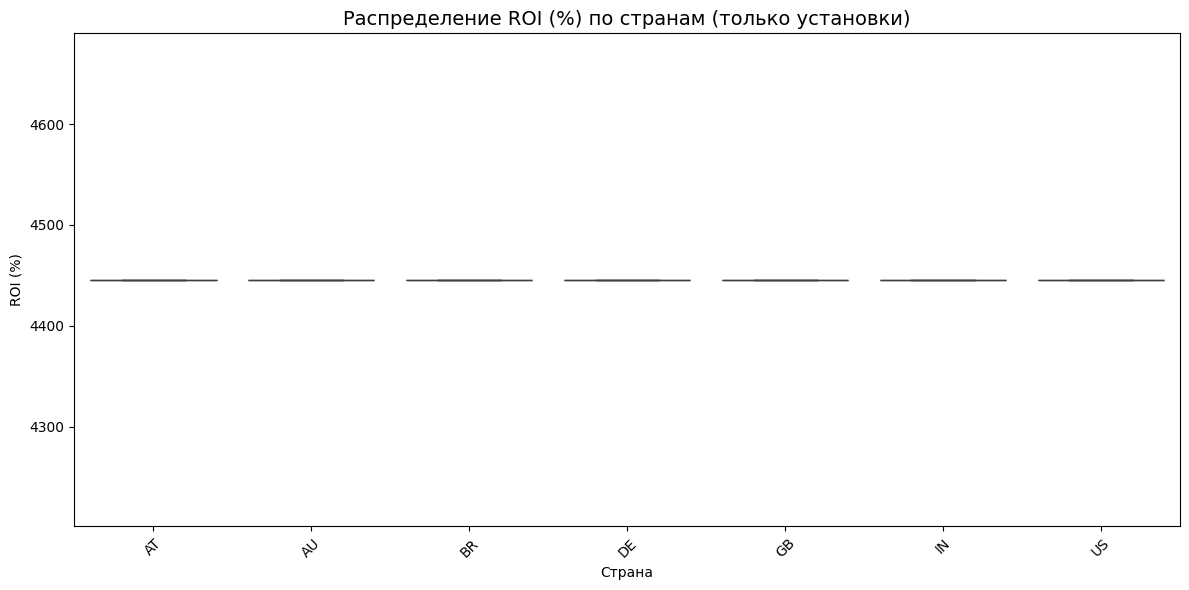

In [21]:
# Построение boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=country_with_installs,
    x='country',
    y='roi'
)

plt.title('Распределение ROI (%) по странам (только установки)', fontsize=14)
plt.xlabel('Страна')
plt.ylabel('ROI (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Из полученного графика видно, соотношение прибыли к затратам по каждой рекламе фиксировано независимо от страны

Изучим распределение показов и конверсию в установку в разбивке по категориальным признакам.

In [22]:
# Построим таблицу для каждого признака
for feature in ['game_app', 'country', 'advertiser',
                'age', 'user_quality_score', 'carrier', 'time_of_day']:

    # Количество показов по каждому признаку
    total = advertisers.groupby(feature)['user_id'].nunique() \
                       .reset_index() \
                       .rename(columns={'user_id': 'Всего показов'})

    # Количество установок по каждому признаку
    users_installed = advertisers[advertisers['install'] == 1].copy() \
                       .groupby(feature)['user_id'].nunique() \
                       .reset_index() \
                       .rename(columns={'user_id': 'Всего установок'})

    # Объединяем данные
    merged_data = total.merge(
        users_installed,
        on=feature,
        how='inner'
    )

    # Рассчитываем долю установок
    merged_data['Доля установок, %'] = (
        merged_data['Всего установок'] / merged_data['Всего показов']
    )

    # Сортируем и форматируем
    merged_data = merged_data.sort_values(
        by='Доля установок, %',
        ascending=False
    )

    # Применяем стили
    format_dict = {'Доля установок, %': '{:.2%}'}
    styled_data = merged_data.style.format(format_dict).bar(
        color='#b2d8f7',
        axis=0,
        subset='Доля установок, %'
    )

    # Выводим результаты
    print(f"Распределение показов по {feature}:")
    print()
    display(styled_data)
    print('-' * 65)

Распределение показов по game_app:



,game_app,Всего показов,Всего установок,"Доля установок, %"
2,game_2,8359,211,2.52%
4,game_4,8318,191,2.30%
0,game_0,8375,188,2.24%
1,game_1,8346,187,2.24%
5,game_5,8310,180,2.17%
3,game_3,8290,145,1.75%
6,game_6,2,0,0.00%


-----------------------------------------------------------------
Распределение показов по country:



,country,Всего показов,Всего установок,"Доля установок, %"
5,IN,7122,172,2.42%
1,AU,7149,169,2.36%
3,DE,7045,165,2.34%
0,AT,7272,164,2.26%
6,US,7157,155,2.17%
2,BR,7140,146,2.04%
4,GB,7115,131,1.84%


-----------------------------------------------------------------
Распределение показов по advertiser:



,advertiser,Всего показов,Всего установок,"Доля установок, %"
10,advertiser_10,1665,45,2.70%
18,advertiser_18,1639,43,2.62%
23,advertiser_23,1643,43,2.62%
17,advertiser_17,1586,40,2.52%
28,advertiser_28,1674,42,2.51%
1,advertiser_01,1592,39,2.45%
0,advertiser_00,1700,41,2.41%
5,advertiser_05,1668,40,2.40%
15,advertiser_15,1660,39,2.35%
14,advertiser_14,1705,40,2.35%


-----------------------------------------------------------------
Распределение показов по age:



,age,Всего показов,Всего установок,"Доля установок, %"
0,1,10701,889,8.31%
1,2,9900,118,1.19%
2,3,9878,49,0.50%
3,4,9715,35,0.36%
4,5,9806,11,0.11%


-----------------------------------------------------------------
Распределение показов по user_quality_score:



,user_quality_score,Всего показов,Всего установок,"Доля установок, %"
0,1,17059,678,3.97%
1,2,16710,315,1.89%
2,3,16231,109,0.67%


-----------------------------------------------------------------
Распределение показов по carrier:



,carrier,Всего показов,Всего установок,"Доля установок, %"
18,carrier_8,2582,72,2.79%
3,carrier_11,2518,65,2.58%
10,carrier_18,2480,61,2.46%
0,carrier_0,2536,62,2.44%
4,carrier_12,2383,58,2.43%
5,carrier_13,2436,58,2.38%
8,carrier_16,2531,59,2.33%
1,carrier_1,2482,57,2.30%
15,carrier_5,2476,56,2.26%
19,carrier_9,2576,56,2.17%


-----------------------------------------------------------------
Распределение показов по time_of_day:



,time_of_day,Всего показов,Всего установок,"Доля установок, %"
3,ночь,14566,351,2.41%
0,утро,14597,316,2.16%
2,вечер,10481,219,2.09%
1,день,10356,216,2.09%


-----------------------------------------------------------------


В приложении `game_6` всего 2 показа. Возможно при записи данных по данному приложению произошла техническая ошибка. Таким образом, показы по данному приложению будут несопоставимы с другими приложениями. Так как объем данных крайне мал, можем отфильтровать их из таблицы без ущерба для дальнейшего анализа результатов.

In [23]:
# Фильтруем данные, убирая показы по game_6
advertisers = advertisers[~advertisers['game_app'].isin(['game_6'])]

# Удаляем неиспользуемые категории
advertisers['game_app'] = advertisers['game_app'].cat.remove_unused_categories()

## Вывод

Предварительный анализ данных показал их достаточно высокое качество. В данных нет пропусков и дубликатов. Информация по показам представлена за полный месяц с 01.02.2023 по 28.02.2023.
В столбцах, содержащих информацию о финансовых показателях `spending` и  `earning`, аномальных значений нет.

Большая часть значений в столбце `earning` нулевые, что коррелирует с описанием данных. Реклама действительно недостаточно эффективна.

Проверка значений в столбце  `install` показала, что признак присвоен корректно и верно коррелирует со значением в `earning`. Для показов, которые привели к установке приложения, все значения в `earning` отличны от 0. Для показов, которые не привели к установке, значения в `earning` равны 0.

В ходе обработки были произведены следующие преобразования:

- Наименования приведены к snake_case;
- Произведено понижение разрядности в столбцах, содержащих числовые данные;
- Тип данных изменен на `categorical` для столбцов `game_app`, `country`, `advertiser`, `carrier`, `mccmnc `;
- Произведено преобразование даты в столбце `createdat` к `datetime`;
- Дополнительно добавлен категориальный признак `time_of_day`, представляющий время суток, в котором был произведен показ рекламы;
- Дополнительно добавлены столбцы `profit` и `loss` с прибылью и убытками от показов;
- При помощи фильтрации убраны показы по `game_6`. Было выявлено, что по данному приложению содержится информация только по двум показам, что делает это приложение несопоставимым с другими. Так как объем данных крайне мал, можем отфильтровать эти строки без искажения результатов дальнейшего анализа.

Кроме того, в данных был обнаружен признак `carrier`, не указанный в изначальном описании к данным. Вероятно, он относится к формату рекламы в приложении (баннер, межстраничная реклама, вознаграждаемая видео-реклама и.т.д.)

Показы распределены равномерно между различными категориальными признаками.

Возможно оценки вероятности по `user_quality_score` присвоены некорректно, так как доля установок среди пользователей с самой высокой оценкой самая низкая, и наоборот.

На следующем этапе погрузимся в анализ подробнее сформулируем гипотезы для проверки.

# Гипотезы

## **Гипотеза 1**: Средняя прибыль с показа в группе молодых пользователей (18-25 лет) в топ-3 приложениях по прибыльности статистически значимо выше, чем в остальных приложениях.

Углубимся в анализ показов пользователей молодой группы.
Не лишним будет проанализировать прибыльность показов для данной категории пользователей.

Рассмотрим, в каких приложениях реклама приносит наибольшую прибыль.

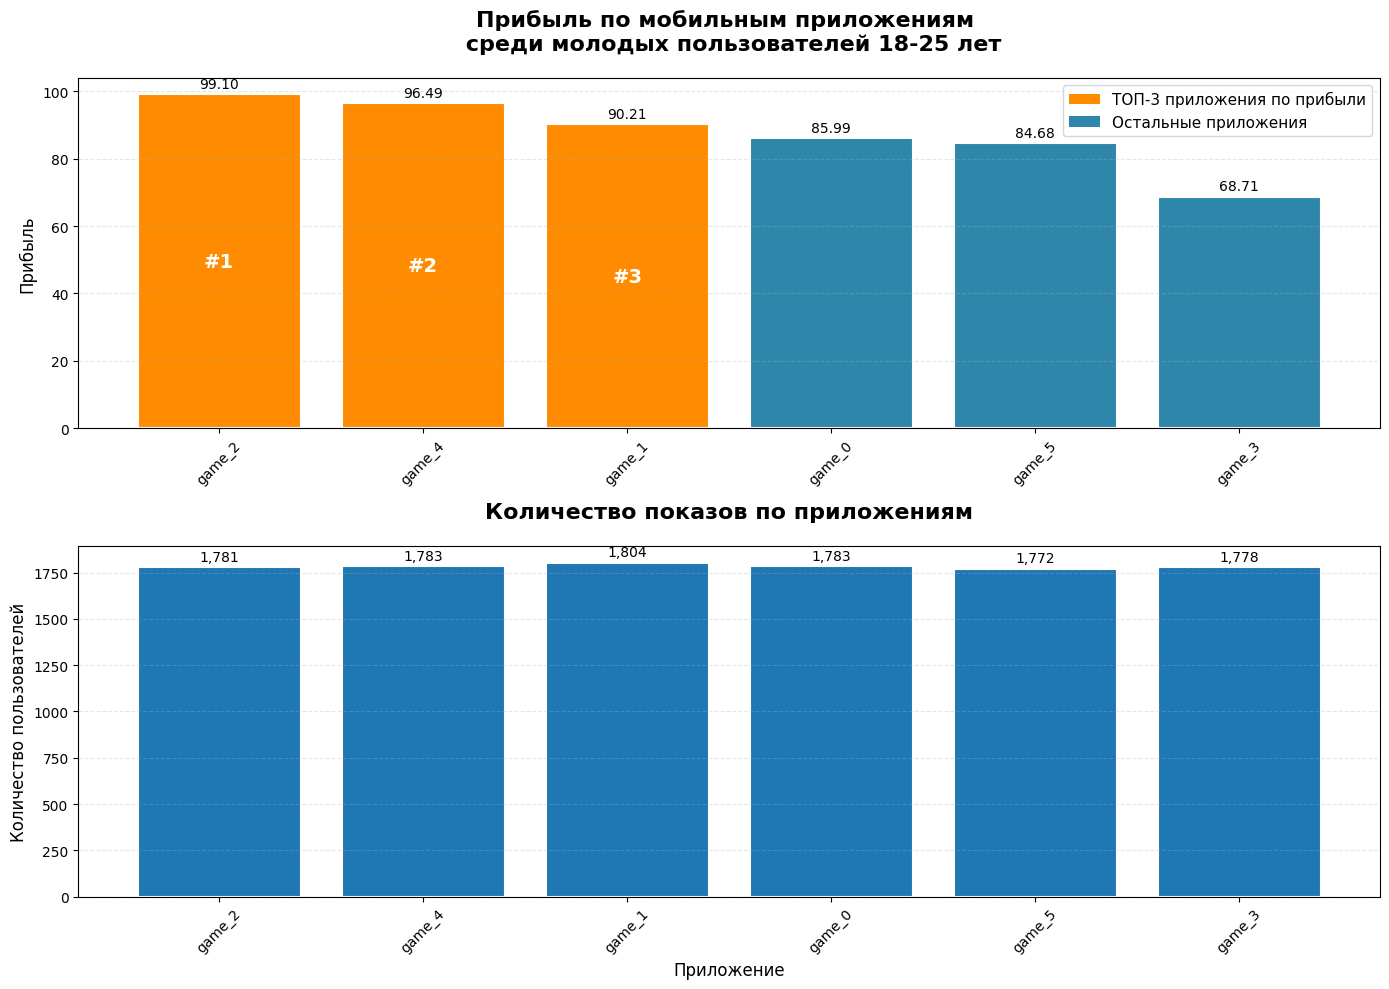

In [24]:
# Агрегируем данные по прибыли в группе молодых пользователей
youth_activity = advertisers[advertisers['age']==1].copy()

youth_income = youth_activity.groupby('game_app').agg(
    {'profit': 'sum', 'user_id': 'nunique'}
).sort_values(by='profit', ascending=False)

# Подготовка данных
apps = youth_income.index.tolist()
profits = youth_income['profit'].values
shows = youth_income['user_id'].values

# Определяем топ-3 приложения по прибыли
top3_indices = youth_income['profit'].nlargest(3).index.tolist()
top3_mask = [app in top3_indices for app in apps]

# Создаем цвета: топ-3 - оранжевый, остальные - синий
colors_profit = ['#FF8C00' if is_top else '#2E86AB' for is_top in top3_mask]

# Создаем фигуру
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# График 1: Прибыль по приложениям
bars1 = axes[0].bar(apps, profits, color=colors_profit, edgecolor='white', linewidth=1.5)
axes[0].set_title('Прибыль по мобильным приложениям \n среди молодых пользователей 18-25 лет',
                  fontsize=16, fontweight='bold', pad=20)
axes[0].set_ylabel('Прибыль', fontsize=12)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
axes[0].tick_params(axis='x', rotation=45)

# Добавляем значения на столбцы
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + max(profits)*0.01,
                f'{height:,.2f}', ha='center', va='bottom', fontsize=10)

# График 2: Количество пользователей по приложениям
bars2 = axes[1].bar(apps, shows, edgecolor='white', linewidth=1.5)
axes[1].set_title('Количество показов по приложениям',
                  fontsize=16, fontweight='bold', pad=20)
axes[1].set_ylabel('Количество пользователей', fontsize=12)
axes[1].set_xlabel('Приложение', fontsize=12)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
axes[1].tick_params(axis='x', rotation=45)

# Добавляем значения на столбцы
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + max(shows)*0.01,
                f'{height:,.0f}', ha='center', va='bottom', fontsize=10)

# Создаем легенду для топ-3
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#FF8C00', label='ТОП-3 приложения по прибыли'),
    Patch(facecolor='#2E86AB', label='Остальные приложения')
]

# Добавляем легенду на первый график
axes[0].legend(handles=legend_elements, loc='upper right', fontsize=11)

# Подписываем топ-3 приложения
top3_profits = youth_income.loc[top3_indices, 'profit']
top3_names = top3_indices

# Добавляем аннотации для топ-3 на графике прибыли
for i, (app, profit) in enumerate(zip(top3_names, top3_profits)):
    idx = apps.index(app)
    axes[0].text(idx, profit * 0.5, f"#{i+1}",
                 ha='center', va='center', fontsize=14,
                 fontweight='bold', color='white')

plt.tight_layout()
plt.show()

Анализ показал, что наибольшая прибыль с показов в приложениях `game_2`, `game_4` и `game_1`. При этом распределение показов между различными приложениями одинаковое. На основании этого можем объединить приложения в две тройки:

- Топ-3 по прибыльности - приложения 1,2,4;
- Наименьшая средняя прибыль с показа - приложения 0,3,5.

Рассмотрим, как меняется значение средней прибыли с показа, в группировке по тройкам.

In [25]:
# Средняя прибыль с показа по топ-3
top_3_sum = youth_activity[
    youth_activity['game_app'].isin(['game_1', 'game_2', 'game_4'])
]['profit'].mean()

# Средняя прибыль с показа по остальным
low_3_sum = youth_activity[
    youth_activity['game_app'].isin(['game_0', 'game_3', 'game_5'])
]['profit'].mean()

print(f"Средняя прибыль показа для топ-3: {top_3_sum:.2f}")
print(f"Средняя прибыль показа для остальных: {low_3_sum:.2f}")

Средняя прибыль показа для топ-3: 0.05
Средняя прибыль показа для остальных: 0.04


Различие в средней прибыли с показа действительно существует и составляет `0.01`.

На основании этого можно выдвинуть гипотезу "Средняя прибыль с показа в группе молодых пользователей (18-25 лет) в топ-3 приложениях по прибыльности (game_1, game_2, game_4) статистически значимо выше, чем в остальных приложениях (game_0, game_3, game_5)".

### Проверка гипотезы

Определимся с выбором подходящего статистического теста для проверки данной гипотезы.

Обозначим группу game_0, game_3, game_5 за группу A соответственно, а game_1, game_2, game_4 за группу B.

Тогда гипотезы:

$$H_0: \mu_B <= \mu_A$$
$$H_1: \mu_B > \mu_A$$

Для проверки различий в средних значениях как правило используется t-тест.
Так как объем выборок достаточно большой (> 5000 наблюдений в каждой, соблюдается условие n >= 30), согласно ЦПТ распределение выборочных средних будет стремиться к нормальному. Это является важным и необходимым условием при проведении t-теста.

Существует две разновидности t-теста:

- Тест Стьюдента - требует равенства дисперсий;
- Тест Уэлча - не требует равенства диспресий.

Проверим равенство дисперсий между выборками. Для этого применим статистический тест Левене.

In [26]:
# Средняя прибыль с показа по топ-3
top_3 = youth_activity[
    youth_activity['game_app'].isin(['game_1', 'game_2', 'game_4'])
]['profit']

# Средняя прибыль с показа по остальным
low_3 = youth_activity[
    youth_activity['game_app'].isin(['game_0', 'game_3', 'game_5'])
]['profit']

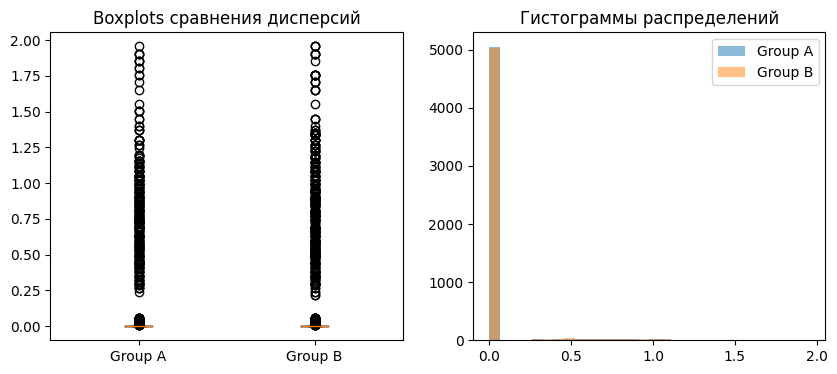

Тест Левене: p_value = 0.0434
Дисперсии не равны → t-тест Уэлча


In [27]:
def choose_t_test_version(data_a, data_b, alpha=0.05):
    """
    Проверяет равенство дисперсий
    """
    n_a, n_b = len(data_a), len(data_b)

    # 1. Всегда проверяем визуально
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].boxplot([data_a, data_b], labels=['Group A', 'Group B'])
    axes[0].set_title('Boxplots сравнения дисперсий')

    axes[1].hist(data_a, alpha=0.5, label='Group A', bins=30)
    axes[1].hist(data_b, alpha=0.5, label='Group B', bins=30)
    axes[1].set_title('Гистограммы распределений')
    axes[1].legend()

    plt.show()

    # Проверяем тестом Левене
    _, p_levene = st.levene(data_b, data_a, center='median')
    print(f"Тест Левене: p_value = {p_levene:.4f}")

    # Принимаем решение
    if p_levene > alpha:
        print("Дисперсии равны → обычный t-тест")
        return True
    else:
        print("Дисперсии не равны → t-тест Уэлча")
        return False

# Применяем для выборк с значениями прибыли
test_type = choose_t_test_version(low_3, top_3)

Так как дисперсии в выборках неравны применим т-тест Уэлча.
Уровень значимости $\alpha$ возьмем 0.05.

In [28]:
# Создаем группы: B = топ-3, A = остальные
youth_activity['test_group'] = youth_activity['game_app'].apply(
    lambda x: 'B' if x in top3_indices else 'A'
)

# Проверяем распределение
print("\nРаспределение событий по группам:")
group_dist = youth_activity['test_group'].value_counts()
print(group_dist)


Распределение событий по группам:
test_group
B    5368
A    5333
Name: count, dtype: int64


In [29]:
# Применяем т-тест
test_result = ttest_ind(top_3,
                        low_3,
                        alternative = 'greater',
                        equal_var=test_type)

# Задаем значения alpha и находим pvalue
alpha = 0.05
test_result.pvalue

# Выводим результат т-теста
if test_result.pvalue <= alpha:
    print(f'Полученное значение p_value:{round(test_result.pvalue,2)} меньше установленного значения alpha:{alpha}.\nПринимаем альтернативную гипотезу.')
else:
    print(f'Полученное значение p_value:{round(test_result.pvalue,2)} больше установленного значения alpha:{alpha}.\nНулевая гипотеза не может быть отвергнута.')


Полученное значение p_value:0.02 меньше установленного значения alpha:0.05.
Принимаем альтернативную гипотезу.


На основании полученного `p_value` принимаем альтернативную гипотезу. Средняя прибыль от показов в приложениях `game_1`,`game_2` и `game_4` статистически значимо выше, чем в остальных.

### **Вывод по гипотезе**:
#### В качестве приоритетных каналов для распространения рекламы необходимо использовать приложения game_2, game_4 и game_1.


## **Гипотеза 2**: Среднее количество просмотров, приходящееся на одну установку, в группе молодых пользователей (18-25 лет) статистически значимо меньше среднего для генеральной совокупности.

In [30]:
def viewing_for_conv(df: pd.DataFrame) -> float:
    """
    Возвращает среднее число просмотров, приходящееся
    на одну установку.

    Args:
        df (pd.DataFrame): датафрейм.

    Returns:
        mean_viewing (float): среднее число просмотров.
    """

    df = df.reset_index(drop=True)
    viewing_cnt_lst = []
    viewing_cnt = 1
    lines_cnt = df.shape[0]
    for index, row in df.iterrows():
        if index > 0:
            if df.loc[index-1,'install'] == 0:
                viewing_cnt += 1
            else:
                viewing_cnt_lst.append(viewing_cnt)
                viewing_cnt = 1
    mean_viewing = round(sum(viewing_cnt_lst) / len(viewing_cnt_lst), 2)
    return mean_viewing

Основываясь на результатах разбивки конверсии по возрастным группам, выдвигается гипотеза, о том, что среднее количество просмотров, приходящееся на одну установку, в группе молодых пользователей (18-25 лет) статистически значимо меньше среднего для генеральной совокупности. Адекватность гипотезы обосновывается сопоставлением расчётных значений среднего числа просмотров, приходящегося на одну установку, для отдельных возрастных групп и для набора данных в целом.

In [31]:
mean_res = viewing_for_conv(advertisers)
print(f'Среднее число просмотров на одну установку: {mean_res} ед.')

age_group_lst = ['18–25', '26–35', '36–45', '46–55', '55+']
viewing_lst = []
for i, age_group in enumerate(age_group_lst):
    mean_res_i = viewing_for_conv(advertisers[advertisers['age'] == i + 1])
    print(f'Среднее число просмотров на одну установку для возрастной группы \
{age_group} лет - {mean_res_i} ед.')
    viewing_lst.append(mean_res_i)

Среднее число просмотров на одну установку: 45.36 ед.
Среднее число просмотров на одну установку для возрастной группы 18–25 лет - 12.02 ед.
Среднее число просмотров на одну установку для возрастной группы 26–35 лет - 83.75 ед.
Среднее число просмотров на одну установку для возрастной группы 36–45 лет - 199.69 ед.
Среднее число просмотров на одну установку для возрастной группы 46–55 лет - 277.43 ед.
Среднее число просмотров на одну установку для возрастной группы 55+ лет - 883.82 ед.


По результатам расчёта строится столбиковая диаграмма.

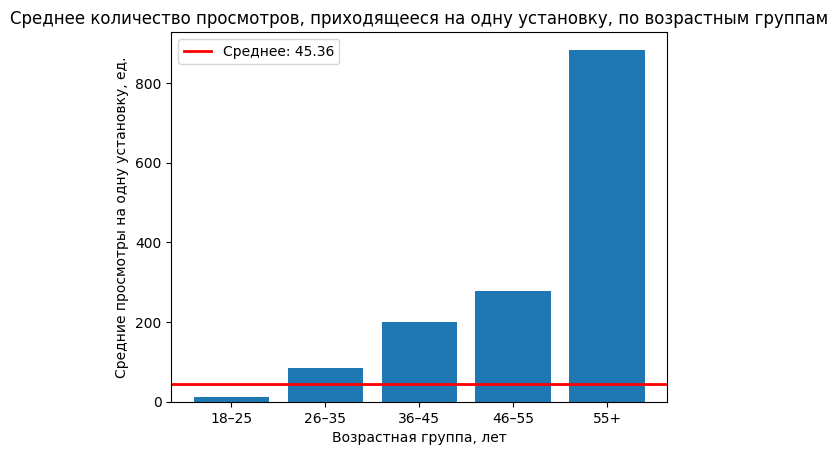

In [32]:
plt.bar(age_group_lst, viewing_lst)
plt.axhline(y=mean_res, color='red', linewidth=2,
            label=f'Среднее: {mean_res}')
plt.legend(bbox_to_anchor=(0, 1), loc='upper left')
plt.xlabel('Возрастная группа, лет')
plt.ylabel('Средние просмотры на одну установку, ед.')
plt.title('Среднее количество просмотров, приходящееся на одну установку, \
по возрастным группам')
plt.show()

Из столбиковой диаграммы следует, что среднее количество просмотров, приходящееся на одну установку, в возрастной группе 18-25 лет существенно меньше среднего по всему набору данных (примерно в 4 раза). Из этого следует, что может быть целесообразным направлять рекламные компании именно на эту возрастную группу, например, за счёт снижения затрат на рекламу для группы "55+", показывающей наименьшую покупательную активность.

### Проверка гипотезы

Для формирования numpy-массивов значений просмотров, приходящихся на одну становку в различных группах, модифицируется функция viewing_for_conv.

In [33]:
def viewing_for_conv_np(df: pd.DataFrame) -> np.array:
    """
    Возвращает np-массив со значениями просмотров,
    приходящимися на одну установку.

    Args:
        df (pd.DataFrame): датафрейм.

    Returns:
        np.array: просмотры на одну установку.
    """

    df = df.reset_index(drop=True)
    viewing_cnt_lst = []
    viewing_cnt = 1
    lines_cnt = df.shape[0]
    for index, row in df.iterrows():
        if index > 0:
            if df.loc[index-1,'install'] == 0:
                viewing_cnt += 1
            else:
                viewing_cnt_lst.append(viewing_cnt)
                viewing_cnt = 1
    return np.array(viewing_cnt_lst)

Вывод массива значений просмотров, приходящихся на одну установку, для исследуемого датафрейма.

In [34]:
np.set_printoptions(threshold=sys.maxsize)
viewing_general = viewing_for_conv_np(advertisers)
viewing_general

array([ 67,  39,  13, 159,  77,  52, 102,  76,  27,  13,  68,  36,  13,
         6,  25,  10,  68,  66,  78,  31,  36,  93,  15,  47,  39,  66,
        27,   2,  63,  85,  84,  10, 109,  13,  38,   1,  35,  18,  19,
        34,   7,  72,   4, 270,  15,  12,  41,   2,   4,  46, 128,  71,
         1,  53,  34,  88, 177,  25,  91,   1,   1,  27,  27,  13, 129,
        70,  36,  90,  11,   2,  13,   2,   3,  27,   7,  32,  82,  33,
       113,   7,   7, 126,   6,   5, 110,   9,  44,  63,  28,   4,   8,
        55,  34,  15,   5,  38,  14,  13,  34,  38, 257,  52,  37,  66,
         9,  57,  19,  35,  56,   8,  59,  17,  60,  15,  81,  39,  96,
        52, 142, 140,  50,  18,  11, 162, 105,  71,  13,  15,   6,  73,
        10,  21,  65,   7,   4,   8,  14,  79,  28,  34,  87,  29, 232,
        82,  21,   4,  20, 155,  64,   4,   1,  45,   7,   4,  12,  30,
         3,  30,  44, 106,  29,   3,  43,  83,  43,  13,   4,  38,   1,
         7, 126,  34,  22,  30,   5,  35,  20,  26,  75, 148,  1

Вывод массива значений просмотров, приходящихся на одну установку, для группы 18-25 лет.

In [35]:
viewing_first_gr = viewing_for_conv_np(advertisers[advertisers['age'] == 1])
viewing_first_gr

array([15, 12,  3, 30, 18, 13, 16, 19,  4,  3, 17,  5,  2,  2,  6,  4, 14,
        9, 13,  5, 40, 11, 11, 13,  8,  1, 13, 16, 14,  5, 26,  4,  8,  7,
        5,  3,  9,  3, 17, 46,  3,  1, 10,  1,  1, 35, 12,  1,  9, 23, 26,
        7, 17,  1, 10,  6, 34, 16, 11, 25,  2,  4,  8,  1, 20, 26,  2,  1,
       27,  3,  2, 24,  7, 15,  5,  2,  5, 21,  1,  8,  3,  2,  6,  4, 59,
       41,  3, 14,  6,  9,  9,  2, 18,  4, 16, 22,  9, 16, 11, 34, 37, 21,
       72, 19,  3,  2,  1, 15,  3,  3, 13,  2,  1,  3,  3, 15, 11, 11, 19,
       52, 18,  5,  2,  5, 34, 14,  2,  1, 10,  3,  5,  8,  1, 10, 33,  9,
       19,  8,  4,  1,  5,  1, 37,  5,  4,  3,  9,  3,  5, 15, 41, 27, 17,
        8, 29,  5, 22, 34, 10, 12,  7,  4,  9, 10, 12,  2,  6,  6,  1, 12,
       30, 28,  3,  2,  9, 24, 13, 10,  7, 12,  2, 25,  7,  9,  2, 27,  5,
        8,  6,  6,  1,  2,  9,  6,  5,  9,  3,  5,  9,  1, 25,  3,  9,  3,
       22, 22,  6, 20,  3,  3,  1, 28, 31,  9, 27,  6, 10,  6,  6, 28,  2,
       32,  1, 15, 11,  4

Проверка одинаковости дисперсий в группе 18-25 лет и совокупности значений просмотров выполняется с помощью функции variance_check. Функция выполняет для двух проверяемых выборок тест Левена, а также позволяет сравнить их дисперсии на диаграмме.

In [36]:
def variance_check(arr1: np.array, arr2: np.array) -> bool:
    """
    Возвращает^: столбиковую диаграмму дисперсий выборок,
    результат выполнения теста Левена,
    решение о применимости t-теста Стьюдента для
    сравнения средних значений выборок.

    Args:
        arr1 (np.array): первая выборка,
        arr2 (np.array): вторая выборка.

    Returns:
        bool: применимость t-теста Стьюдента.
    """

    # Строим столбиковую диаграмму для дисперсий выборок
    var_lst = [np.var(x, ddof=1) for x in [arr1, arr2]]
    fig, ax = plt.subplots()
    colors = ['green', 'red']
    if var_lst[0] > var_lst[1]:
        colors.reverse()
    bars = ax.bar(['Выборка 1', 'Выборка 2'], var_lst, color=colors)
    for bar in bars:
        y = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, y + 0.5,
            f'{round(y)}', ha='center', va='bottom')
    ax.set_ylabel('Дисперсия выборок')
    ax.set_title('Сравнение дисперсий в выборках')
    plt.show()

    # Проверяем тестом Левена
    stat, p_levene = st.levene(arr1, arr2, center='median')
    print(f"Тест Левена: p_value = {p_levene:.4f}")

    # Принимаем решение
    alpha = 0.05
    if p_levene > alpha:
        print("Дисперсии статистически равны → t-тест Стьюдента")
        return True
    else:
        print("Дисперсии статистически не равны → t-тест Уэлча")
        return False

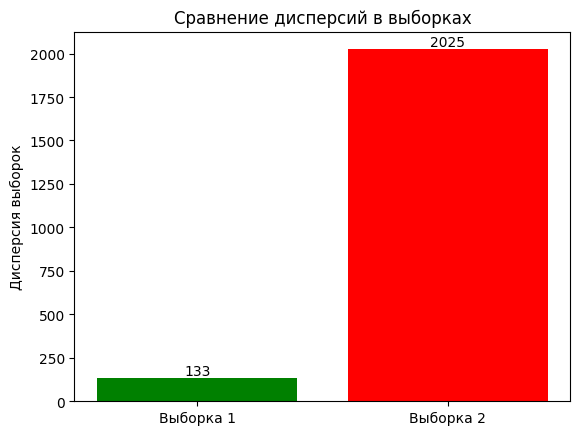

Тест Левена: p_value = 0.0000
Дисперсии статистически не равны → t-тест Уэлча


In [37]:
test_type = variance_check(viewing_first_gr, viewing_general)

Результат теста Левена подтверждает неравенство дисперсий двух выборок, наблюдаемое на диаграмме.
Из-за неравенства дисперсий двух выборок для проверки гипотезы применяется t-тест Уэлча. Проверяемая гипотеза в тесте является альтернативной - среднее количество просмотро на одну установку в группе 18-25 лет меньше (less), чем в исследуемой совокупности.

In [38]:
#применяем t-тест
test_result = st.ttest_ind(viewing_first_gr,
                           viewing_general,
                           alternative='less',
                           equal_var=test_type)

#задаем значения alpha и находим p-value
alpha = 0.05
test_result.pvalue

#выводим результат t-теста
if test_result.pvalue <= alpha:
    print(f'Полученное значение p-value: \
{round(test_result.pvalue, 2)} меньше установленного значения \
alpha = {alpha}.\nОтвергаем нулевую гипотезу.')
else:
    print(f'Полученное значение p-value: \
{round(test_result.pvalue, 2)} больше установленного значения \
alpha: {alpha}.\nНе отвергаем нулевую гипотезу.')

Полученное значение p-value: 0.0 меньше установленного значения alpha = 0.05.
Отвергаем нулевую гипотезу.


По результатам t-теста Уэлча нулевая гипотеза отвергается в пользу альтернативной. Таким образом проверяемая гипотеза подтверждается.

### **Вывод по гипотезе**:
#### - Рекламные компании целесообразно, в первую очередь, ориентировать на возрастную группу 18-25 лет.
#### - Рекламный ресурс может быть переориентирован с пользователей старше 35 лет на молодых пользователей.

## **Гипотеза 3**: Среднее количество просмотров, приходящееся на одну установку, в группе пользователей из страны GB статистически значимо больше среднего для генеральной совокупности.

Основываясь на результатах разбивки конверсии по странам, выдвигается гипотеза, о том, что среднее количество просмотров, приходящееся на одну установку, в группе пользователей из страны GB статистически значимо больше среднего для генеральной совокупности. Адекватность гипотезы обосновывается сопоставлением расчётных значений среднего числа просмотров, приходящегося на одну установку, для отдельных стран и для набора данных в целом.

In [39]:
countries_lst = ['AT', 'AU', 'BR', 'DE', 'GB', 'IN', 'US']
viewing_lst = []
for i in countries_lst:
    mean_res_i = viewing_for_conv(advertisers[advertisers['country'] == i])
    print(f'Среднее число просмотров на одну установку для страны {i} - \
{mean_res_i} ед.')
    viewing_lst.append(mean_res_i)

Среднее число просмотров на одну установку для страны AT - 44.21 ед.
Среднее число просмотров на одну установку для страны AU - 42.28 ед.
Среднее число просмотров на одну установку для страны BR - 48.77 ед.
Среднее число просмотров на одну установку для страны DE - 42.63 ед.
Среднее число просмотров на одну установку для страны GB - 53.92 ед.
Среднее число просмотров на одну установку для страны IN - 41.31 ед.
Среднее число просмотров на одну установку для страны US - 45.17 ед.


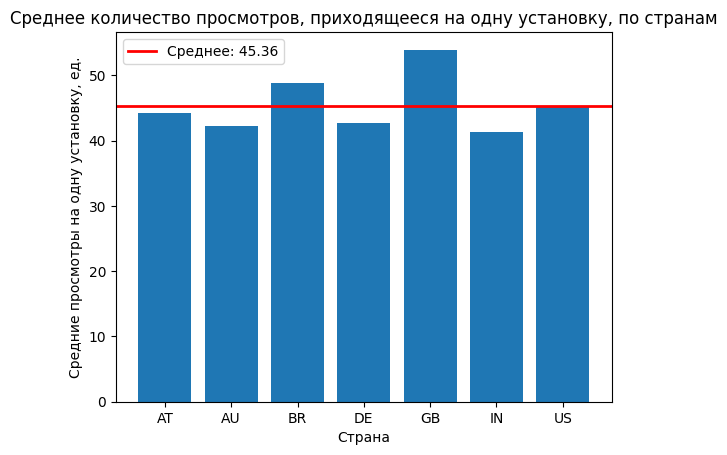

In [40]:
# Построим столбиковую диаграмму
plt.bar(countries_lst, viewing_lst)
plt.axhline(y=mean_res, color='red', linewidth=2,
            label=f'Среднее: {mean_res}')
plt.legend(bbox_to_anchor=(0, 1), loc='upper left')
plt.xlabel('Страна')
plt.ylabel('Средние просмотры на одну установку, ед.')
plt.title('Среднее количество просмотров, приходящееся на одну установку, \
по странам')
plt.show()

Из столбиковой диаграммы следует, что среднее количество просмотров, приходящееся на одну установку, для GB существенно больше среднего по всему набору данных (примерно в 1,2 раза). Из этого следует, что может быть целесообразным более качественно адаптировать рекламные компании под эту страну, чтобы вывести конверсию в ней на средний уровень.

### Проверка гипотезы

Вывод массива значений просмотров, приходящихся на одну установку, для группы пользователей из страны GB.

In [41]:
viewing_GB = viewing_for_conv_np(advertisers[advertisers['country'] == 'GB'])
viewing_GB

array([104,  71,  15,  56,  21,  74,  14,  60, 107,  54,  91,  39, 150,
        15,  23,  72,   3,  27,  23,   8,  57,  24, 156, 106, 124,  16,
        68, 122,  49,  25,  35,  33,  32,  39,  23,  54,  32,  21,  15,
        41,  33,   6,  43,   5, 123,  79,  20,  17,  21,   1,   6,  37,
        94,  62,  57,  13,  11,  21,  12, 197,   7,  60,  24,   2,  97,
       211,   8,   7,  19, 100,  37,  27,  36,  46,  90,  52, 135, 188,
        26,  10,  22,  42,  57,  59,   3,   3,  45,  56,  36,  22, 101,
        48, 139,  22,  59,  42,  65, 159,  47,  68,  21,  67,  70, 111,
         8,  26,  70,  16,  31,  52,  13, 113,  64,   8,  60, 251, 147,
        58,  65,  17,   1,  12,  92, 104, 101,  14,  20, 101,  48,  17,
        51])

Проверка одинаковости дисперсий для группы пользователей из GB и для совокупности значений просмотров.

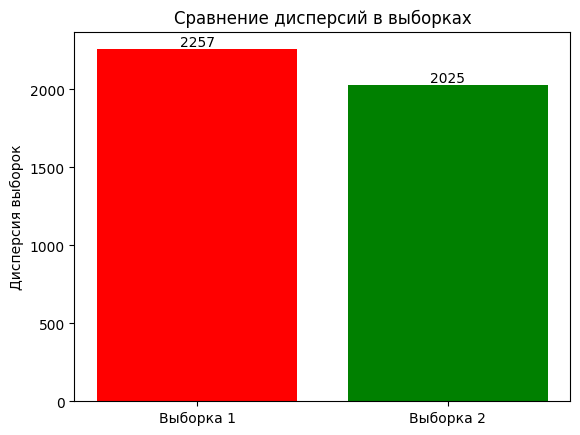

Тест Левена: p_value = 0.2937
Дисперсии статистически равны → t-тест Стьюдента


In [42]:
test_type = variance_check(viewing_GB, viewing_general)

Результат теста Левена подтверждает близость дисперсий двух выборок, наблюдаемую на диаграмме. Из-за равенства дисперсий двух выборок для проверки гипотезы применяется t-тест Стьюдента. Проверяемая гипотеза в тесте является альтернативной - среднее количество просмотро на одну установку в группе пользователей из GB больше (greater), чем в исследуемой совокупности.

In [43]:
#применяем t-тест
test_result = st.ttest_ind(viewing_GB,
                           viewing_general,
                           alternative='greater',
                           equal_var=test_type)

#задаем значения alpha и находим p-value
alpha = 0.05
test_result.pvalue

#выводим результат t-теста
if test_result.pvalue <= alpha:
    print(f'Полученное значение p-value: \
{round(test_result.pvalue, 2)} меньше установленного значения \
alpha = {alpha}.\nОтвергаем нулевую гипотезу.')
else:
    print(f'Полученное значение p-value: \
{round(test_result.pvalue, 2)} больше установленного значения \
alpha: {alpha}.\nНе отвергаем нулевую гипотезу.')

Полученное значение p-value: 0.02 меньше установленного значения alpha = 0.05.
Отвергаем нулевую гипотезу.


По результатам t-теста Стьюдента нулевая гипотеза отвергается в пользу альтернативной. Таким образом проверяемая гипотеза подтверждается.

### **Вывод по гипотезе**:
#### Необходимо рассмотреть экономическую целесообразность адаптации рекламных компаний под пользователей из Великобритании.


## Общие выводы по результатам проверок гипотез

1. Средняя прибыль от показов в приложениях game_1, game_2 и game_4 статистически значимо выше, чем в остальных.
2. Среднее количество просмотров на установку в группе молодых пользователей (18-25 лет) статистически значимо ниже, чем в остальных возрастных группах.
3. Среднее количество просмотров, приходящееся на одну установку, для GB статистически значимо выше среднего по всему набору данных.

Рекомедации для разработки модели, прогнозирующей прибыльность рекламного показа:
*   Стоит рассмотреть увеличение бюджета на `game_1`, `game_2` и `game_4`;
*   Необходимо качественно адаптировать рекламные компании под конкретную страну (на примере GB);
*   Целесообразно увеличить рекламные компании на возрастную группу "18-25" лет и снизить долю затрат на рекламу для группы "55+".

# Визуализации для дашборда

Создадим дашборд из двух вкладок:

- На вкладке 1 разместим общую статистику по показам, установкам и конверсии;
- На вкладке 2 разместим визуализацию к гипотезам 1, 2 и 3.

In [44]:
# ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ

def create_empty_figure(message, height=400):
    """Создание пустого графика с сообщением об ошибке"""
    empty_fig = go.Figure()
    empty_fig.update_layout(
        title=dict(text=message, font=dict(size=14)),
        xaxis_title="",
        yaxis_title="",
        template='plotly_white',
        height=height
    )
    return empty_fig


def find_alternative_column(possible_cols, df):
    """Поиск альтернативной колонки"""
    for col in possible_cols:
        if col in df.columns:
            return col
    return None

In [45]:
# ВКЛАДКА 1: Общая статистика конверсии

def prepare_feature_data(feature, top_n=20):
    """Подготовка данных для выбранного признака"""
    # Преобразуем feature в строку, если это категориальная переменная
    if pd.api.types.is_categorical_dtype(advertisers[feature]):
        advertisers[feature] = advertisers[feature].astype(str)

    # Количество уникальных пользователей (показов) по признаку
    total = advertisers.groupby(feature)['user_id'].nunique() \
                       .reset_index() \
                       .rename(columns={'user_id': 'Всего показов'})

    # Количество установок по признаку
    users_installed = advertisers[advertisers['install'] == 1].copy() \
                       .groupby(feature)['user_id'].nunique() \
                       .reset_index() \
                       .rename(columns={'user_id': 'Всего установок'})

    # Объединяем данные
    merged_data = total.merge(
        users_installed,
        on=feature,
        how='left'
    ).fillna(0)

    # Убедимся, что все числовые колонки имеют правильный тип
    merged_data['Всего показов'] = merged_data['Всего показов'].astype(int)
    merged_data['Всего установок'] = merged_data['Всего установок'].astype(int)

    # Рассчитываем конверсию
    merged_data['Доля установок, %'] = (
        merged_data['Всего установок'] / merged_data['Всего показов'].replace(0, np.nan) * 100
    ).round(2).fillna(0)

    # Сортируем по конверсии
    merged_data = merged_data.sort_values(
        by='Доля установок, %',
        ascending=False
    )

    # Ограничиваем количество строк для отображения
    if len(merged_data) > top_n:
        display_data = merged_data.head(top_n).copy()
        # Собираем данные для "Остальных"
        others_impressions = merged_data.iloc[top_n:]['Всего показов'].sum()
        others_installs = merged_data.iloc[top_n:]['Всего установок'].sum()
        others_conversion = (others_installs / others_impressions * 100) if others_impressions > 0 else 0

        # Создаем DataFrame для остальных
        others_data = {
            feature: [f'Остальные ({len(merged_data)-top_n})'],
            'Всего показов': [int(others_impressions)],
            'Всего установок': [int(others_installs)],
            'Доля установок, %': [float(round(others_conversion, 2))]
        }

        others_df = pd.DataFrame(others_data)
        display_data = pd.concat([display_data, others_df], ignore_index=True)
    else:
        display_data = merged_data

    return display_data

def create_visualizations(feature, top_n, sort_by, min_impressions=0):
    """Создание визуализаций для выбранного признака"""
    # Получаем данные
    df = prepare_feature_data(feature, top_n)

    # Фильтрация по минимальному количеству показов
    df = df[df['Всего показов'] >= min_impressions]

    # Сортировка
    sort_column = {
        'conversion': 'Доля установок, %',
        'impressions': 'Всего показов',
        'installs': 'Всего установок'
    }[sort_by]

    df = df.sort_values(sort_column, ascending=False)

    # Убедимся, что feature - строка для отображения
    df[feature] = df[feature].astype(str)

    # Создаем subplot с тремя графиками в ряд
    fig = make_subplots(
        rows=1, cols=3,
        subplot_titles=(
            f'Конверсия по {feature}',
            'Распределение показов',
            'Распределение установок'
        ),
        horizontal_spacing=0.1
    )

    # График 1: Конверсия (столбчатая диаграмма)
    conversion_median = df['Доля установок, %'].median()
    colors_conversion = [
        '#2E86AB' if x >= conversion_median else '#A23B72'
        for x in df['Доля установок, %']
    ]

    fig.add_trace(
        go.Bar(
            x=df[feature].astype(str),
            y=df['Доля установок, %'],
            name='Конверсия',
            marker_color=colors_conversion,
            hovertemplate='<b>%{x}</b><br>Конверсия: %{y:.2f}%<br>Показов: %{customdata[0]:,}<extra></extra>',
            customdata=df[['Всего показов']].values
        ),
        row=1, col=1
    )

    # График 2: Показы (столбчатая диаграмма)
    fig.add_trace(
        go.Bar(
            x=df[feature].astype(str),
            y=df['Всего показов'],
            name='Показы',
            marker_color='#FF9F1C',
            hovertemplate='<b>%{x}</b><br>Показов: %{y:,}<extra></extra>'
        ),
        row=1, col=2
    )

    # График 3: Установки (столбчатая диаграмма)
    fig.add_trace(
        go.Bar(
            x=df[feature].astype(str),
            y=df['Всего установок'],
            name='Установки',
            marker_color='#E71D36',
            hovertemplate='<b>%{x}</b><br>Установок: %{y:,}<br>Конверсия: %{customdata:.2f}%<extra></extra>',
            customdata=df['Доля установок, %']
        ),
        row=1, col=3
    )

    # Обновляем layout
    fig.update_layout(
        title=f'Анализ конверсии по признаку: {feature}',
        showlegend=False,
        template='plotly_white',
        height=500,
        hovermode='closest',
        margin=dict(t=100)
    )

    # Настройка осей
    for i in range(1, 4):
        fig.update_xaxes(tickangle=45, row=1, col=i)

    fig.update_yaxes(title_text="Конверсия (%)", row=1, col=1)
    fig.update_yaxes(title_text="Количество показов", row=1, col=2)
    fig.update_yaxes(title_text="Количество установок", row=1, col=3)

    # Подготовка данных для таблицы
    table_data = df.copy()
    table_data = table_data.rename(columns={
        feature: 'Значение',
        'Всего показов': 'Показов',
        'Всего установок': 'Установок',
        'Доля установок, %': 'Конверсия, %'
    })

    # Форматирование для таблицы
    table_data['Показов'] = table_data['Показов'].apply(lambda x: f"{int(x):,}")
    table_data['Установок'] = table_data['Установок'].apply(lambda x: f"{int(x):,}")
    table_data['Конверсия, %'] = table_data['Конверсия, %'].apply(lambda x: f"{x:.2f}%")

    # Общая статистика
    total_impressions = df['Всего показов'].sum()
    total_installs = df['Всего установок'].sum()
    overall_conversion = (total_installs / total_impressions * 100) if total_impressions > 0 else 0

    # Подготовка статистики в виде таблицы
    stats_data = pd.DataFrame({
        'Метрика': [
            'Выбранный признак',
            'Уникальных значений',
            'Общая конверсия',
            'Максимальная конверсия',
            'Средняя конверсия',
            'Минимальная конверсия',
            'Всего показов',
            'Всего установок'
        ],
        'Значение': [
            feature,
            str(len(df)),
            f"{overall_conversion:.2f}%",
            f"{df['Доля установок, %'].max():.2f}%",
            f"{df['Доля установок, %'].mean():.2f}%",
            f"{df['Доля установок, %'].min():.2f}%",
            f"{int(total_impressions):,}",
            f"{int(total_installs):,}"
        ]
    })

    return fig, table_data[['Значение', 'Показов', 'Установок', 'Конверсия, %']], stats_data

def update_tab1(feature, top_n, sort_by, min_impressions):
    """Обновление вкладки 1"""
    try:
        # Преобразуем min_impressions в число
        try:
            min_impressions = int(min_impressions)
        except:
            min_impressions = 0

        plot, table, stats = create_visualizations(feature, top_n, sort_by, min_impressions)
        return plot, table, stats
    except Exception as e:
        # Создаем пустой график в случае ошибки
        empty_fig = go.Figure()
        empty_fig.update_layout(
            title=f"Ошибка при обработке признака '{feature}': {str(e)}",
            xaxis_title="",
            yaxis_title="",
            template='plotly_white'
        )
        return empty_fig, pd.DataFrame(), pd.DataFrame({'Метрика': ['Ошибка'], 'Значение': [str(e)]})

In [46]:
# ВКЛАДКА 2: Визуализация к гипотезе 1

def create_youth_profit_tab():
    """Создание визуализации прибыли по приложениям для молодых пользователей"""

    # Фильтруем молодых пользователей (age == 1)
    youth_activity = advertisers[advertisers['age'] == 1].copy()

    if youth_activity.empty:
        return create_empty_figure("Нет данных для пользователей 18-25 лет")

    # Агрегируем данные по прибыли
    youth_income = youth_activity.groupby('game_app').agg(
        {'profit': 'sum', 'user_id': 'nunique'}
    ).sort_values(by='profit', ascending=False)

    # Если нет колонки profit, пробуем другие
    if 'profit' not in youth_activity.columns:
        profit_col = find_alternative_column(['revenue', 'earning', 'income', 'value'], youth_activity)
        if not profit_col:
            return create_empty_figure("Отсутствуют данные о прибыли")

        youth_income = youth_activity.groupby('game_app').agg(
            {profit_col: 'sum', 'user_id': 'nunique'}
        ).sort_values(by=profit_col, ascending=False)
        profit_data = youth_income[profit_col].values
    else:
        profit_data = youth_income['profit'].values

    # Подготовка данных
    apps = youth_income.index.tolist()

    # Определяем топ-3 приложения по прибыли
    top3_indices = youth_income.nlargest(3, youth_income.columns[0]).index.tolist()
    top3_mask = [app in top3_indices for app in apps]

    # Создаем цвета
    colors = ['#FF8C00' if is_top else '#2E86AB' for is_top in top3_mask]

    # Создаем график
    fig = go.Figure()

    fig.add_trace(go.Bar(
        x=apps,
        y=profit_data,
        marker_color=colors,
        marker_line_color='white',
        marker_line_width=1.5,
        opacity=0.9,
        hovertemplate='<b>%{x}</b><br>Прибыль: $%{y:,.2f}<br>Пользователей: %{customdata:,}<extra></extra>',
        customdata=youth_income['user_id'].values if 'user_id' in youth_income.columns else [0]*len(apps)
    ))

    # Добавляем аннотации для топ-3
    for i, app in enumerate(top3_indices):
        if app in apps:
            idx = apps.index(app)
            profit_value = profit_data[idx]
            fig.add_annotation(
                x=app,
                y=profit_value * 0.5,
                text=f"#{i+1}",
                showarrow=False,
                font=dict(size=16, color='white', weight='bold'),
                align='center'
            )

    # Обновляем layout
    fig.update_layout(
        xaxis=dict(
            title='Приложение',
            tickangle=45,
            tickfont=dict(size=12),
            showgrid=False,
            automargin=True
        ),
        yaxis=dict(
            title='Прибыль ($)',
            tickformat=',.0f',
            gridcolor='lightgray',
            gridwidth=0.5,
            automargin=True
        ),
        template='plotly_white',
        height=500,
        hovermode='closest',
        margin=dict(t=50, b=100, l=50, r=30)
    )

    # Добавляем легенду
    fig.add_annotation(
        x=0.01, y=1.05,
        xref="paper", yref="paper",
        text="<span style='color:#FF8C00'>■</span> ТОП-3 приложения",
        showarrow=False,
        font=dict(size=12),
        align='left',
        bgcolor='rgba(255,255,255,0.8)'
    )

    fig.add_annotation(
        x=0.01, y=1.02,
        xref="paper", yref="paper",
        text="<span style='color:#2E86AB'>■</span> Остальные",
        showarrow=False,
        font=dict(size=12),
        align='left',
        bgcolor='rgba(255,255,255,0.8)'
    )

    return fig

In [47]:
# ВКЛАДКА 2: Визуализация к гипотезе 2

def create_age_viewing_tab():
    """Создание графика просмотров на установку по возрастным группам"""

    try:
        if 'age' not in advertisers.columns or 'install' not in advertisers.columns:
            return create_empty_figure("Отсутствуют колонки age или install")

        # Функция расчета
        def viewing_for_conv(df):
            if df.empty:
                return 0
            df = df.reset_index(drop=True)
            viewing_cnt_lst = []
            viewing_cnt = 1

            for index in range(1, len(df)):
                if df.loc[index-1, 'install'] == 0:
                    viewing_cnt += 1
                else:
                    viewing_cnt_lst.append(viewing_cnt)
                    viewing_cnt = 1

            if viewing_cnt > 0:
                viewing_cnt_lst.append(viewing_cnt)

            return round(sum(viewing_cnt_lst) / len(viewing_cnt_lst), 2) if viewing_cnt_lst else 0

        # Рассчитываем данные
        mean_res = viewing_for_conv(advertisers)
        age_group_lst = ['18–25', '26–35', '36–45', '46–55', '55+']
        viewing_lst = []

        for i in range(1, 6):
            viewing_lst.append(viewing_for_conv(advertisers[advertisers['age'] == i]))

        # Создаем график
        fig = go.Figure()

        fig.add_trace(go.Bar(
            x=age_group_lst,
            y=viewing_lst,
            marker_color='steelblue',
            marker_line_color='white',
            marker_line_width=1.5,
            opacity=0.9,
            hovertemplate='<b>%{x}</b><br>Просмотры: %{y:.2f} ед.<extra></extra>'
        ))

        # Добавляем линию среднего
        fig.add_hline(
            y=mean_res,
            line_dash="dash",
            line_color="red",
            line_width=2,
            annotation_text=f"Среднее: {mean_res}",
            annotation_position="top right",
            annotation_font_size=12
        )

        # Обновляем layout
        fig.update_layout(
            xaxis=dict(title='Возрастная группа', tickfont=dict(size=11)),
            yaxis=dict(title='Просмотры на установку, ед.', tickfont=dict(size=11)),
            template='plotly_white',
            height=400,
            hovermode='closest',
            margin=dict(t=40, b=50, l=50, r=30)
        )

        return fig

    except Exception as e:
        return create_empty_figure(f"Ошибка: {str(e)}")

In [48]:
# ВКЛАДКА 2: Визуализация к гипотезе 3

def create_country_viewing_tab():
    """Создание графика просмотров на установку по странам (гипотеза 2)"""

    try:
        # Проверяем наличие необходимых колонок
        if 'country' not in advertisers.columns or 'install' not in advertisers.columns:
            return create_empty_figure("Отсутствуют колонки country или install")

        # Функция расчета просмотров на установку
        def viewing_for_conv(df):
            """Возвращает среднее число просмотров на одну установку"""
            if df.empty:
                return 0

            df = df.reset_index(drop=True)
            viewing_cnt_lst = []
            viewing_cnt = 1

            for index in range(1, len(df)):
                if df.loc[index-1, 'install'] == 0:
                    viewing_cnt += 1
                else:
                    viewing_cnt_lst.append(viewing_cnt)
                    viewing_cnt = 1

            # Добавляем последнее значение
            if viewing_cnt > 0:
                viewing_cnt_lst.append(viewing_cnt)

            return round(sum(viewing_cnt_lst) / len(viewing_cnt_lst), 2) if viewing_cnt_lst else 0

        # Общее среднее по всем данным
        mean_res = viewing_for_conv(advertisers)

        # Страны для анализа
        countries_lst = ['AT', 'AU', 'BR', 'DE', 'GB', 'IN', 'US']
        viewing_lst = []

        # Рассчитываем для каждой страны
        for country in countries_lst:
            country_data = advertisers[advertisers['country'] == country]
            mean_res_i = viewing_for_conv(country_data)
            viewing_lst.append(mean_res_i)

        # Подсчет для GB отдельно
        gb_data = advertisers[advertisers['country'] == 'GB']
        gb_mean = viewing_for_conv(gb_data)
        gb_multiplier = gb_mean / mean_res if mean_res > 0 else 0

        # Рассчитываем проценты
        percentages = [(val / mean_res * 100) if mean_res > 0 else 0 for val in viewing_lst]

        # Создаем график Plotly
        fig = go.Figure()

        # Определяем цвета: GB выделим оранжевым, остальные - синим
        colors = ['orange' if country == 'GB' else 'steelblue' for country in countries_lst]

        # Добавляем столбцы
        fig.add_trace(go.Bar(
            x=countries_lst,
            y=viewing_lst,
            marker_color=colors,
            marker_line_color='white',
            marker_line_width=1.5,
            opacity=0.9,
            hovertemplate='<b>%{x}</b><br>' +
                         'Средние просмотры: %{y:.2f} ед.<br>' +
                         f'Общее среднее: {mean_res:.2f} ед.<br>' +
                         'Отношение: %{customdata:.1f}%' +
                         '<extra></extra>',
            customdata=percentages,
            name='Страны'
        ))

        # Линия общего среднего
        fig.add_hline(
            y=mean_res,
            line_dash="dash",
            line_color="red",
            line_width=2,
            annotation_text=f"Общее среднее: {mean_res}",
            annotation_position="top right",
            annotation_font_size=12,
            annotation_font_color="red"
        )

        # Аннотация для GB
        if gb_mean > mean_res * 1.1:  # Если GB > среднего на 10%
            fig.add_annotation(
                x='GB',
                y=gb_mean + max(viewing_lst) * 0.05,
                text=f"GB: {gb_mean:.2f} ед.<br>(в {gb_multiplier:.1f} раза больше)",
                showarrow=True,
                arrowhead=2,
                arrowsize=1,
                arrowwidth=2,
                arrowcolor="orange",
                font=dict(size=12, color="orange", weight="bold"),
                align="center",
                bgcolor="rgba(255,255,255,0.9)",
                bordercolor="orange",
                borderwidth=1,
                borderpad=4
            )

        # Обновляем layout
        fig.update_layout(
            xaxis=dict(
                title='Страна',
                tickfont=dict(size=11),
                showgrid=False
            ),
            yaxis=dict(
                title='Средние просмотры на одну установку, ед.',
                tickfont=dict(size=11)
            ),
            template='plotly_white',
            hovermode='closest',
            showlegend=False,
            margin=dict(t=80, b=60, l=60, r=40)
        )

        # Добавляем легенду
        fig.add_annotation(
            x=0.01, y=1.05,
            xref="paper", yref="paper",
            text="<span style='color:orange'>■</span> GB (особый интерес)",
            showarrow=False,
            font=dict(size=11),
            align='left',
            bgcolor='rgba(255,255,255,0.8)'
        )

        fig.add_annotation(
            x=0.01, y=1.02,
            xref="paper", yref="paper",
            text="<span style='color:steelblue'>■</span> Остальные страны",
            showarrow=False,
            font=dict(size=11),
            align='left',
            bgcolor='rgba(255,255,255,0.8)'
        )

        return fig

    except Exception as e:
        return create_empty_figure(f"Ошибка при создании графика: {str(e)}")

In [49]:
# СОЗДАНИЕ ДАШБОРДА
with gr.Blocks(title="Аналитический дашборд",
               theme=gr.themes.Soft(primary_hue="blue")) as dashboard:

    gr.Markdown("# Анализ конверсии, прибыли и эффективности по различным сегментам")

    with gr.Tabs():
        # Вкладка 1: Анализ конверсии
        with gr.TabItem("Конверсия по признакам"):
            with gr.Row():
                with gr.Column(scale=1):
                    gr.Markdown("### Настройки анализа")

                    available_features = [f for f in ['game_app', 'country', 'advertiser', 'age']
                                         if f in advertisers.columns]

                    feature_selector = gr.Dropdown(
                        choices=available_features,
                        value=available_features[0] if available_features else None,
                        label="Выберите признак"
                    )

                    top_n_slider = gr.Slider(5, 50, 15, step=1, label="Top N")
                    min_impressions_input = gr.Number(0, label="Мин. показов")

                    sort_selector = gr.Radio(
                        [("По конверсии", "conversion"), ("По показам", "impressions"), ("По установкам", "installs")],
                        value="conversion",
                        label="Сортировка"
                    )

                with gr.Column(scale=2):
                    gr.Markdown("### Визуализации")
                    gr.Markdown("### Значения конверсии ниже медианного выделены фиолетовым")
                    plot_output = gr.Plot()

            with gr.Row():
                table_output = gr.Dataframe(headers=["Значение", "Показов", "Установок", "Конверсия, %"], wrap=True)

            with gr.Row():
                stats_output = gr.Dataframe(headers=["Метрика", "Значение"], wrap=True)

        # Вкладка 2: Гипотезы
        with gr.TabItem("Анализ гипотез"):
            # Первый график: Гипотеза 1
            gr.Markdown("### Гипотеза 1: Прибыль по приложениям (18-25 лет)")
            gr.Markdown("ТОП-3 приложения по прибыли выделены оранжевым")
            plot_hypothesis1 = gr.Plot()

            gr.Markdown("---")

            # Два графика рядом
            with gr.Row():
                with gr.Column():
                    # Гипотеза 2
                    gr.Markdown("### Гипотеза 2: Просмотры на установку по возрастам")
                    plot_hypothesis2 = gr.Plot()

                with gr.Column():
                    # Гипотеза 3
                    gr.Markdown("### Гипотеза 3: Просмотры на установку по странам")
                    plot_hypothesis3 = gr.Plot()

    # Обработчики событий
    inputs_tab1 = [feature_selector, top_n_slider, sort_selector, min_impressions_input]
    outputs_tab1 = [plot_output, table_output, stats_output]

    for component in [feature_selector, top_n_slider, sort_selector, min_impressions_input]:
        component.change(update_tab1, inputs_tab1, outputs_tab1)

    # Инициализация
    dashboard.load(lambda f, t, s, m: update_tab1(f, t, s, m), inputs_tab1, outputs_tab1)

    # Для гипотезы 1
    dashboard.load(create_youth_profit_tab, [], [plot_hypothesis1])

    # Для гипотезы 2
    dashboard.load(create_age_viewing_tab, [], [plot_hypothesis2])

    # Для гипотезы 3
    dashboard.load(create_country_viewing_tab, [], [plot_hypothesis3])

# Запуск
if __name__ == "__main__":
    dashboard.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f0562ee9cf2f92fd01.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
